<a href="https://colab.research.google.com/github/vicentcamison/idal_ia3/blob/main/3%20Aprendizaje%20profundo%20(II)/Sesion%201/05_Pytorch_MLP_b%C3%A1sico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#<strong>**Máster en Inteligencia Artificial Avanzada y Aplicada  IA^3**</strong>
---


##<center>**Preceptrón multicapa (_MLP_) con Pytorh** </center>

En este notebook vamos a estudiar los siguientes aspectos:
 
 * Creación de una red neuronal con capas ocultas
 * Incorporación del uso de funciones de activación no lineales
 * Aprovechameiento del uso de GPU (si es posible) para acelerar el entrenamiento
 * Experimantar con hiperparámetros para mejorar el modelo. 

### Usando GPU para entrenar más rápido

Como ya sabemos, uno de los motivos del gran desarrollo y auge que estamos experimentando en el machine learning y especialmente en deep learning es debido a la posibilidad de aprovechar **GPU** [Graphics Processing Unit](https://en.wikipedia.org/wiki/Graphics_processing_unit)  para entrenar a los modelos de una forma mucho más rápida. 
Dependiendo de la plataforma que empleemos será conveniente seguir algunas instrucciones: 
* _Google Colab_: Usa el menu option "Entorno de Ejecución > Cambiar tipo de entorno de Ejecucion" y selecciona "GPU" del menu "Acelerador por Hardware".
* _Kaggle Kernel_: En el menu de opciones de la barra superior (los tres puntos), selecciona "GPU" del menu "Acelerador"
* _Linux_: Si tu equipo de sobremesa o portátil tiene una tarjeta NVIDIA GPU (graphics card), asegurate que tienes instalados los drivers correctos y actualizados [Linux NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-linux/index.html).
* _Windows_: Si tu equipo de sobremesa o portátil tiene una tarjeta NVIDIA GPU (graphics card), asegurate que tienes instalados los drivers correctos y actualizados [Windows NVIDIA CUDA drivers](https://docs.nvidia.com/cuda/cuda-installation-guide-microsoft-windows/index.html).
* _macOS_: macOS no es compatible con NVIDIA GPUs
 
Si no tienes acceso a GPU no es problema ya que este notebook se puede ejecutar igulmente en una CPU normal ;)

## Preparando los datos

En el cuaderno anterior, estudiamos como podíamos entrenar un modelo de regresión logística para identificar números escritos a mano del MNIST dataset, obteniendo una precisión de en torno al 86%. Cada número era una imagen de 28x28 píxeles en escala de grises. Recordemos el aspecto que tenía el datasetHere are some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

Ya vimos que es bastante dificil mejorar dicha precisión, a pesar de dedicar más entrenamiento y jugar con los parámetros, empleando simplemente una regresión logística. Esto es así porque el modelo que desarrollamos asume que hay una relación lineal entre las entradas (intensidades de píxeles) y la salida (el número que representan). Y esto puede (probablemente) no ser cierto. 

Vamos a desarrollar un nuevo modelo simple de red neuronal que va a ser capaz de capturar esas relaciones no lineales que nos faltan para mejorar el resultado con dicho dataset: un perceptrón multicapa básico. 
Empezamos importando los módulos y clases necesarios de `torch`, `torchvision`, `numpy`, y `matplotlib`.

In [ ]:
# Si ejecutas el notebook de forma local, descomenta la linea que corresponda a tu sistema operativo para instalar las libreriás correspondientes

# Linux / Binder
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# Windows
# !pip install numpy matplotlib torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# MacOS
# !pip install numpy matplotlib torch torchvision torchaudio

In [ ]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Fondo blanco para todas las figuras matplotlib 
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

Descargamos los datos y generamos un PyTorch dataset a partir de la clase` MNIST` de `torchvision.datasets`. 

In [ ]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Vamos a visualizar algunas imágenes. Recordemos que las imagenes han sido convertidas a tensores Pytorch con la forma `1x28x28` (canales de color, ancho y alto). Podemos emplear el método `plt.imshow` para ver las imágenes.

image.shape: torch.Size([1, 28, 28])
Label: 5


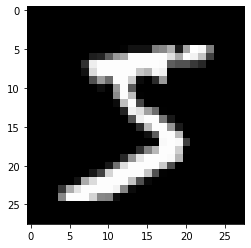

In [ ]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 0


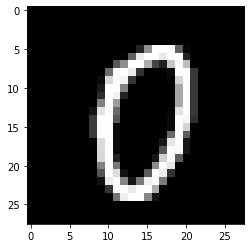

In [ ]:
image, label = dataset[1000]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', label)

Ahora empleamos el método `random_split` para "apartar" 10000 imagenes para nuestro conjunto de validación.

In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

Y ahora creamos los PyTorch data loaders para entrenamiento y validación, teniendo en cuenta un tamaño de lote especificado.

In [ ]:
batch_size=128

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

Observesen los argumentos`num_workers` and `pin_memory`? Intenta comprender que hacen conslutando la documentación: https://pytorch.org/docs/stable/data.html .

Vamos a visualizar un lote de datos en un formato de rejilla o través de la función  `make_grid` de `torchvision`. Empleamos el método `.permute` en el  tensor para mover los canales como la última dimensión, tal como espera `matplotlib`.

images.shape: torch.Size([128, 1, 28, 28])


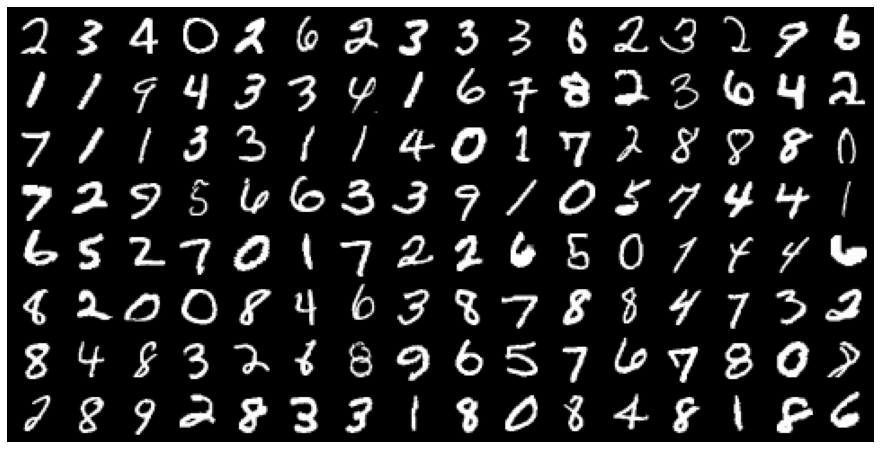

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Capas ocultas, funciones de activación y No-linearidad

Vamos a crear una red neuronal básica, con una _capa de entrada_, una _capa oculta_  y una _capa de salida_. La capa oculta incorporará una _función de activación_. 
Vamos a estudiar un ejemplo paso a paso de forma que podamos apreciar como el hecho de emplear capas ocultas y funciones de activación va apermitir capturar esas relaciones no lineales entre entradas y salidas

Inicaialmente crearemos un lote de tensores de entrada. "Extenderemos" sus dimensiones de imagenes de `1x28x28` a vectores de longitud `784`, y los pasaremos a un objeto `nn.Linear`.

In [ ]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Creamos el objeto `nn.Linear` que emplearemos como capa oculta (_hiden layer_). Adjudicamos un tamaño inicial de 32 neuronas a esta capa. Este número puede ser aumentado o disminuido y eso afectará a la capacidad de aprndizaje que puede desarrollar el modelo. 

In [ ]:
input_size = inputs.shape[-1]
hidden_size = 32

In [ ]:
layer1 = nn.Linear(input_size, hidden_size)

Las salidas intermedas las obtenemos pasando las entradas `inputs` a través de `layer1`.

In [ ]:
inputs.shape

torch.Size([128, 784])

In [ ]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


Observamos ahora que los vectores de las imagenes de tamaño 784 se han transformado en unos vectores intermedios de tamaño 32, a través de la multiplicación de matrices que se ha realizado entre la matriz de `inputs` con la atriz traspuesta de los pesos de `layer1`, a la cual se le añaden los sesgos _bias_. 

Podemos verificar estas operaciones realizandolas de forma manual y comparando los resultados con `torch.allclose`.

In [ ]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [ ]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Así pues, en este punto, `layer1_outputs` y las `inputs` tienen una relación lineal, i.e., cada elemento de `layer_outputs` es una suma ponderada de los valores de `inputs`. En concreto una suma de 728 valores ponderados por 728 coeficientes, para cada salida. Sin embargo, por más que entrenemos el modelo y reajustemos los pesos, `layer1` únicamente será capaz de capturar relaciones lineales entre `inputs` y `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">


Para mejorar esto, lo siguiente que vamos a hacer es emplear la función ReLU (_Rectified Linear Unit_) como función de activación para las salidas. Eta función tiene la fórmula `relu(x) = max(0,x)` i.e. simplemente reemplaza los valores negativos de un tensor dado por el valo 0. ReLU es una función no lineal, como podemos observar:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

Emplearemos el método `F.relu` de `torch.nn.functional` para aplicar ReLU a los elementos de un tensor.

In [ ]:
F.relu(torch.tensor([[1, -1, 0], 
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Aplicamos la función RELU a la salida `layer1_outputs` y verificamos que los valores negativos han sido reemplazados por 0:

In [ ]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.6744487881660461
min(relu_outputs): 0.0


Al aplicar ahora esta función de activación no lineal, `relu_outputs` e `inputs` ya no tienen relación lineal. Nos referimos a ella como _función de activación_ porque en definitiva lo que estamos haciendo es que ciertas salidas se activen (aquellas con valores superiores a cero) mientras que las otras quedan inactivadas. 

Vamos a crear ahora la capa de salida que convertirá los vectores de longitud `hidden_size` en `relu_outputs` dentro de vectores de longitud 10, que es la longitud necesaria para nuestro modelo (hay 10 posibles etiquetas de salida)

In [ ]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [ ]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [ ]:
inputs.shape

torch.Size([128, 784])

Como es de esperar, `layer2_outputs` contiene un lote de vectores de tamaño  10. Ahora emplearemos esa salida para calcular el error empleando  `F.cross_entropy` y ajustando los pesos de las capas `layer1` y `layer2` por descenso de gradiente.

In [ ]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3008, grad_fn=<NllLossBackward>)

Así pues, nuestro modelo transforma las `inputs` a `layer2_outputs` aplicando una transformación lineal (a través de `layer1`), seguida de una activación no lineal (empleando `F.relu`), seguida a su vez de otra transformación lineal (a través de `layer2`). 
Podemos verificar esto recalculando la salida empleando únicamente operaciones básicas entre matrices.

In [ ]:
# Versión expandida de layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [ ]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

Podemos constatar que ahora `outputs` e `inputs` no tienen una relación lineal, debido a la introducción de la función `F.relu`. A medida que entrenamos el modelo y ajustamos los pesos de las capas `layer1` y `layer2`, conseguimos ahora capturar relaciones no lineales entre las imagenes y sus etiquetas. En otras palabras, al introducir la no linealidad hace que el modelo se vuelva más potente y más verátil. Por otro lado `hidden_size`, el tamaño de la capa oculta, no depende de las dimensiones de la entrada ni de las salidas. Podemos incrementarlo o reducirlo, reflejarlo en la mayr o menor cantidad de parámetros que se austarán en el interior del modelo. También podemos insertar otras capas ocultas y aplicar la misma fucnión de activación despues de cada una. 

El modelo que hemos planetado es una red neuronal mínima, también llamado perceptrón multicapa (_Multilayer Perceptron, MLP_). El MLP puede constar de más capas ocultas. De hecho, una red neuronal profunda es simplemente una red neuronal con 2 o más capas ocultas. El [Teorema de Aproximación Universal](http://neuralnetworksanddeeplearning.com/chap4.html) especifica que una red neuronal suficientemente larga y profunda, puede obtener cualquier función, i.e. que puede llegar a aprender relaciones extremadamente complejas entre entradas y salidas. 

Puede ser dificil imaginar como el simple proceso de multiplicar valores de entrada por matrices inicializadas aleatoriamente, aplicar una función básica no lineal muy simple y reajustando pesos repetidamente puede llevar a obtener los resultados que se consiguen en las aplicaciones de las redes neuronales. No obstante, hemos de tener en cuenta que las redes neuronales profundas a menudo contienen **millones de parámetros** que se recalculan y la combinación de todos ellos permite capturar esas relaciones complejas que un cerebro humano no alcanza a captar. 


## Modelo

Ahora estamos listos para definir nuestro modelo. Vamos a crear una red neuronal con una capa oculta, teniendo en cuanta las siguientes consideraciones:  

* En lugar de emplear un único objeto `nn.Linear` para transformar cada lote de entradas (intensidades de pixel) en salidas (probabilidades para cada clase), vamos a emplear dos objetos `nn.Linear`. Cada uno de ellos será una capa llamada _layer_ en la red.

* La primera capa (conocida como capa oculta o _hidden layer_) transforma la matriz de entrada de dimensiones `batch_size x 784` a una matriz intermedia de de forma `batch_size x hidden_size`. El parámetro `hidden_size` se configurará manualmente e indica la cantidad de elementos (neuronas) que ponemos en dicha capa oculta.

* A continuación aplicamos la _función de activación_ a las salidas intermedias. 

* El resultado de la función de activación, que mantiene las dimensiones `batch_size x hidden_size`, es pasado a la segunda capa o capa de salida. Esta capa transforma dicha entrada a una matriz de tamaño `batch_size x 10`. Ahora podemos emplear las salidas obtenidas para calcular el error con respecto a salida correcta y ajustar (actualizar) los pesos empleando descenso de gradiente en un proceso que se llama _backpropagation_.

Visualmente, el modelo quedará como se muestra a continuación. Es lo que se conoce como **arquitectura del modelo** y en redes mayores puede llegar a ser ectremadamente compleja.

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Para definir el modelo, vamos a extender la clase base `nn.Module` de PyTorch.

In [ ]:
class MnistModel(nn.Module):
    """MLP con 1 capa oculta"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Extendemos los tensores de las imagenes
        xb = xb.view(xb.size(0), -1)
        # Salidas inteermedias
        out = self.linear1(xb)
        # Aplicamos función de activación
        out = F.relu(out)
        # Predicciones en la capa de salida
        out = self.linear2(out)
        return out
       
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Genera predicciones
        loss = F.cross_entropy(out, labels) # Calcula loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Genera predicciones
        loss = F.cross_entropy(out, labels)   # Calcula loss
        acc = accuracy(out, labels)           # Calcula accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combina losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combina accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

De igual forma que en el ejemplo de regresión, además de especificar las capas del modelo, definimos otros metodos que nos resultarán útiles para el entrenamiento y control del proceso. 

Vamos a preparar tambien una función que nos calcule la precisión del modelo para un lote dado de entradas. Esta función se llama `accuracy` y la empleamos en el método `validation_step` definido anteriormente.

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Creamos un modelo con una capa oculta de 32 elementos: 

In [ ]:
input_size = 784
hidden_size = 32 # Esto puede configurarse
num_classes = 10

In [ ]:
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)

Comprobamos los parámetros del modelo y que concuerden en dimensiones. Tenemos matrices de pesos y matrices de biases:

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Probamos ahora a generar algunas salidas con el modelo y verificar que funciona. Tomamos el primer lote de 128 imagenes y las pasamos a través del modelo

In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3075199127197266
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.1118, -0.1099, -0.0620,  0.0106,  0.0211, -0.1478,  0.0469, -0.0745,
         -0.0769, -0.2466],
        [-0.0016, -0.0732, -0.0882, -0.0961,  0.0089, -0.1754,  0.1882, -0.0643,
         -0.0878, -0.2533]])


## Usando una GPU

Según se va incrementando el tamaño de los modelos y los conjuntos de datos que empleamos se hace necesario aprovechar GPUs para entrenarlos en unos tiempos razonables. Las GPUs contienen cientos de núcleos optimizados para la realización de operaciónes con matrices de números de coma flotante muy rápido, siendo por tanto ideales para el entrenamiento de redes neuronales. 

Actualmente además, es posible emplear GPUs de forma libre y gratuita en plataformas como [Google Colab](https://colab.research.google.com/) y [Kaggle](https://www.kaggle.com/kernels) o bien alquilar máquinas y tiempos GPUs en servicios como [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html), entre otros (y cada vez más)

Para comprobar si tenemos disponible GPU para el cálculo y sus controladores están instalados emplearemos la función `torch.cuda.is_available`.

In [ ]:
torch.cuda.is_available()

True

Podemos definir una función que realiza esa comprobación y configura el dispositivo para aprovechar la GPU cuando sea posible y cuando no, emplea la CPU: 

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

Ahora será necesario definir una función para mover los datos y el modelo al dispositivo (GPU o CPU) seleccionado.

In [ ]:
def to_device(data, device):
    """Movemos los tensores al dispositivo"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


A través de las dos funciones anteriores, podemos hacer de forma general que automáticamente se seleccione el dispositivo correspondiente (GPU si se puede y si no CPU) y los datos se cargen en él. 

Finalmente, vamos a definir una clase que vamos a llamar `DeviceDataLoader` para encapsular (_wrapp_) nuestros lotes e ir enviandolos adecuadamente al dicpositivos seleccionado. En realidad no necesitamos extender ninguna clase existente de Pytorch para generar nuestro _data loader_. Todo lo que debemos hacer es definir un iterador `__iter__` que vaya tomando lotes y los envíe al dispostivo y un método `__len__` que obtenga el número de lotes.

In [ ]:
class DeviceDataLoader():
    """Encapsula un dataloader para mover los datos al dispositivo device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Itera lotes de datos y los va enviando al device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Numero de lotes"""
        return len(self.dl)

La palabra clave `yield` Python se usa para crear una funcion generadora que se puede empleada en un bucle `for`, com ose ilustra en el ejemplo siguiente: 

In [ ]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


Empleamos `DeviceDataLoader` para encapsular el envío de los datos por lotes al dispositivo que corresponda.

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

Los tensores que se mueven a una GPU tienen una propiedad llamada `device` que es la palabra `cuda`. Podemos verificar esto revisando uno de los lotes con `val_loader`:

In [ ]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([5, 5, 8, 1, 8, 9, 6, 2, 1, 7, 3, 6, 4, 8, 5, 6, 9, 6, 5, 2, 2, 3, 3, 5,
        6, 0, 2, 0, 4, 4, 9, 0, 3, 2, 6, 1, 7, 2, 5, 5, 9, 8, 1, 4, 7, 5, 7, 2,
        4, 1, 0, 7, 6, 8, 1, 0, 0, 2, 1, 5, 7, 1, 7, 3, 4, 4, 7, 3, 9, 4, 9, 3,
        0, 4, 3, 8, 5, 7, 4, 5, 6, 3, 1, 2, 7, 3, 8, 4, 0, 5, 7, 5, 5, 0, 0, 5,
        1, 6, 7, 2, 7, 4, 0, 9, 4, 1, 5, 0, 3, 5, 7, 9, 7, 0, 9, 0, 8, 5, 9, 2,
        5, 6, 3, 2, 9, 9, 9, 8, 9, 9, 1, 8, 0, 6, 2, 1, 7, 0, 9, 3, 2, 8, 1, 1,
        5, 6, 0, 3, 0, 1, 8, 5, 3, 8, 1, 7, 7, 6, 0, 0, 3, 8, 0, 2, 0, 0, 8, 4,
        9, 7, 1, 3, 8, 2, 2, 5, 6, 9, 1, 2, 1, 4, 5, 7, 8, 5, 6, 4, 5, 5, 7, 8,
        9, 0, 2, 3, 8, 3, 0, 7, 9, 5, 3, 0, 1, 4, 1, 6, 5, 4, 7, 3, 9, 8, 4, 4,
        2, 4, 2, 2, 9, 2, 9, 6, 6, 2, 8, 1, 1, 7, 4, 6, 7, 2, 9, 5, 3, 9, 6, 2,
        7, 0, 1, 5, 4, 1, 5, 6, 9, 9, 2, 1, 1, 5, 8, 1], device='cuda:0')


## Entrenamiento

Definiremos nuestras funciones `fit` and `evaluate` para entrenar el modelo, de forma similar al notebook anterior. 
Recordemos que estas funciones están planteadas para que sean independientes del modelo planteado (definido con la clase `MnistModel`), realizando los pasos generales para el ajuste del modelo, i.e., para cada lote realizamos entrenamiento, cálculo de error, calculo de gradientes, actualización de pesos, reset de gradientes, evaluación en validación y guardado de resultados en una lista (`history[]`)

In [ ]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Antes de entrenar hemos de asegurarnos que tanto los datos como los parámetros del modelo (pesos y biases) están en el **mismo dispositivo** (CPU o GPU). Para ello podemos aprovechar la función deinida anteriormente `to_device`para mover los parámetros del modelo al dispositivo correcto:

In [ ]:
# Modelo (a GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.16103515028953552, 'val_loss': 2.2978596687316895}]

La precisión inicial está en torno al 10%, lo cual como ya sabemos es lo esperable dado que tenemos 10 posibles salidas y hemos inicializado aleatoriamente los pesos y biases.

Continuamos entrenando 5 ciclos _epochs_ más para ver el avance. Dado queestamos en una fase inicial, vamos a usar una tasa de aprendizaje relativamente alto de 0.5.

In [ ]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss: 0.2419, val_acc: 0.9285
Epoch [1], val_loss: 0.1908, val_acc: 0.9416
Epoch [2], val_loss: 0.1504, val_acc: 0.9548
Epoch [3], val_loss: 0.1430, val_acc: 0.9555
Epoch [4], val_loss: 0.1414, val_acc: 0.9555


Realmente hemos mejorado mucho! 96% es un muy buen resultado. Podemos probar a seguir entrenando, esta vez con un ratio de aprendizaje menor para intentar afinar en nuestro ajuste y mejorar los resultados.

In [ ]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.1100, val_acc: 0.9651
Epoch [1], val_loss: 0.1089, val_acc: 0.9646
Epoch [2], val_loss: 0.1082, val_acc: 0.9649
Epoch [3], val_loss: 0.1064, val_acc: 0.9656
Epoch [4], val_loss: 0.1057, val_acc: 0.9659


Vamos a graficar los resultados y de esa froma estudiar como el modelo va mejorando con respecto a los ciclos que entrena.

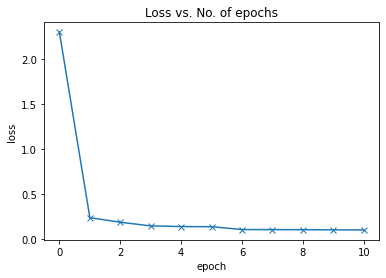

In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

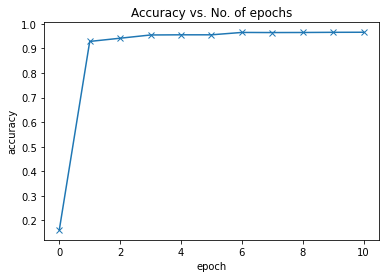

In [ ]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Observamos que el modelo ha conseguido superar (con los mismos datos) los resultados obtenidos con el modelo de regresion logística (que estaban en torna al 86%) El modelo con un MLP simple (una sola capa oculta) rápidamente ha obtenido cerca de un 97% lo cual es muy buen resultado, aunque parece que ya no mejora mucho más. Para conseguir mejorar más, tendríamos que plantear modelos más potentes incrementando el número de elementos en la capa oculta o directamente el número de capas. 

## Test con imágenes individuales

Además de llevar un seguimiento de lo precisión del modelo, tamién resulta interesante explorar los resultados del modelo con ejemplos concretos de imágenes. Vamos a probar el modelo con algunas del conjunto de 10000 imágenes de test. 

Empezamos transformando los datos a tensores con `ToTensor`

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/', 
                     train=False,
                     transform=ToTensor())

Definiremos una función `predict_image` que nos facilitará la predicción devolviendo la etiqueta obtenida para un tensor de imagen individual entrado.

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Probamos con varias imágenes: 

Label: 7 , Predicted: 7


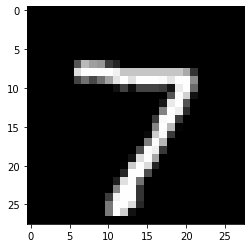

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


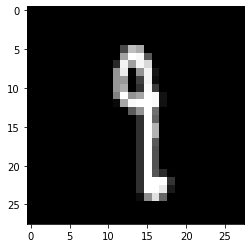

In [ ]:
img, label = test_dataset[4500]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


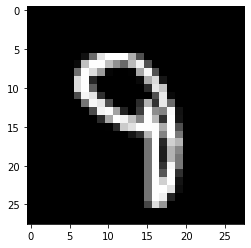

In [ ]:
img, label = test_dataset[193]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

Como ya sabemos, es interesante identificar donde se comporta peor nuestro modelo porque es la forma en que podemos afrontar las diferentes estrategias de mejora, bien recogiendo más datos, ajustando hiperpaámetros, arquitectura de la red, etc.

Com opaso final, vamos a evaluar la pérdida y precisión total para el modelo sobre el conjunto de test.

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.970019519329071, 'val_loss': 0.1050727367401123}

El resultado obtenido debe ser parecido al de entrenamiento. Si no es así, es posible que el conjunto de validación empleado en el entrenamiento no tenga similar distribucion al de test, que a menudo proviene de datos reales. También se pueden dar problemas de sobreajuste. 

## Salvar el modelo 
Vamos a salvar el modelo a disco de forma que podamos recuperar los valores de las matrices de pesos y biases que han sido ajustados. De esta forma un nuevo modelo no tiene porqué empezar desde cero. También nos sirve para continuar el entrenamiento .

In [ ]:
torch.save(model.state_dict(), 'mlp-basico.pth')

## Fin del Notebook

Referencias y modelos empleados para el Notebook: 

*   Documentación de [Pytorch](https://pytorch.org/docs/stable/index.html) 
*   [PyTorch Tutorial for Deep Learning Researchers](https://github.com/yunjey/pytorch-tutorial) by Yunjey Choi
*   [FastAI](https://www.fast.ai/) development notebooks by Jeremy Howard.
*   Documentación y cursos en [Pierian Data](https://www.pieriandata.com/)
*   Tutoriales y notebooks del curso "Deep Learning with Pytorch: Zero to GANs" de [Aakash N S](https://jovian.ai/aakashns)
* [A visual proof that neural networks can compute any function](http://neuralnetworksanddeeplearning.com/chap4.html), también conocido como Teorema de Aproximación Universal
* [But what *is* a neural network?](https://www.youtube.com/watch?v=aircAruvnKk) - Una introducción muy intuitiva a lo que son las redes neuronales y lo que implican las capas ocultas.